In [29]:
import uproot3 as uproot
import uproot_methods
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
import time
import infofile
import numpy as np
import mplhep as hep
from scipy import stats
import boost_histogram as bh
import pandas as pd

In [267]:
#samples = ["zzjj", "ttz", "twz"]
samples = ["twz"]

xsecs= [2530, 759, 116]

BR = [(0.034 + 0.034)**2,
      (0.034 + 0.034) * (0.11 + 0.11) * (0.11 + 0.11),
      (0.034 + 0.034) * (0.11 + 0.11) * (0.11 + 0.11)
      ]
#intLumi = 139.0
intLumi = 3000.0

n_events = 30000

In [268]:
n_exp = np.array([])
n_exp_cuts = np.array([])

plot_n_true_mu = []
plot_n_true_e = []
plot_pt_true_mu = []
plot_pt_true_e = []
plot_iso_mu = []
plot_iso_e = []
plot_ll_masses = []
plot_ll_pt = []
plot_ll_pt_true = []

plot_zpt_diff_xs = []
plot_zpt_diff_xs_true = []

plot_nbtag = []
plot_njet = []
plot_ht = []

bins_n_true_mu = np.linspace(-0.5, 5.5, num=7)
bins_n_true_e = np.linspace(-0.5, 8.5, num=10)
bins_iso_mu = np.linspace(0.0, 0.005, num=30)
bins_iso_e = np.linspace(0.0, 0.005, num=30)
bins_pt_mu = np.linspace(0.0, 100.0, num=30)
bins_pt_e = np.linspace(0.0, 100.0, num=30)
bins_ll_masses = np.linspace(70.0, 150.0, num=30)
bins_ll_pt = np.linspace(0.0, 300.0, num=4)
bins_nbtag = np.linspace(-0.5, 5.5, num=7)
bins_njet = np.linspace(-0.5, 5.5, num=7)
bins_ht = np.linspace(0.0, 300.0, num=2)

for isample in range(0, len(samples)):

    n_mumu_cand = np.array([])
    mumu_cand_masses = np.array([])
    mumu_cand_pts = np.array([])

    n_elel_cand = np.array([])
    elel_cand_masses = np.array([])
    elel_cand_pts = np.array([])

    sample_name = str("delphes_output_") + str(samples[isample]) + str("_4l.root")
    eventsData = uproot.open(sample_name)["Delphes"] 
    eventsData.show()
    EventWeight, EventCrossSection, JetPT, JetEta, JetBTag, MuonPT, MuonEta,  MuonPhi,  MuonT, MuonCharge, MuonIsolationVar, MuonDZ, ElectronPT, ElectronEta,  ElectronPhi,  ElectronT, ElectronCharge, ElectronIsolationVar, ParticlePID, ParticleStatus, ParticleMass, ParticlePT = eventsData.arrays(["Event.Weight", "Event.CrossSection","Jet.PT", "Jet.Eta", "Jet.BTag", "Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.T", "Muon.Charge", "Muon.IsolationVar", "Muon.DZ", "Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.T", "Electron.Charge", "Electron.IsolationVar", "Particle.PID", "Particle.Status","Particle.Mass", "Particle.PT"],outputtype=tuple)

    evWeight = (xsecs[isample] * BR[isample] * intLumi)/n_events
   
    #object-level cuts
    e_cut  = (ElectronPT>10) & (ElectronIsolationVar<0.1) & ( abs(ElectronEta)< 2.5)
    mu_cut  = (MuonPT>10) & (MuonIsolationVar<0.1) & ( abs(MuonEta)< 2.5)
    jet_cut  = (JetPT>20) & (abs(JetEta)< 2.5)
    btag_cut  = (JetBTag==1)
    
    #event-level cuts    
    n_lep_cut = ( ( (ElectronPT[e_cut].counts) + (MuonPT[mu_cut].counts))== 4) 
    sum_charge_cut =  ((ElectronCharge[e_cut].sum()) + (MuonCharge[mu_cut].sum())==0 )
    njet_cut = (JetPT[jet_cut].counts <= 2)
    nbtag_cut = (JetPT[jet_cut & btag_cut].counts == 1)
    
    # flat event cut
    event_cut = (n_lep_cut & sum_charge_cut & njet_cut & nbtag_cut)
    
    #print("baseline selected event:")
    #print(len(EventWeight[event_cut]))
    
    #get array of true z cands for reco-selected events
    z_pt_reco = np.array([])
    z_pt_true_selected_unfolding = np.array([])

    ParticlefUniqueID, ParticlePID, ParticleM1, ParticleStatus, ParticleMass, ParticlePT, ParticleEta, ParticlePhi = eventsData.arrays(["Particle.fUniqueID", "Particle.PID", "Particle.M1", "Particle.Status","Particle.Mass", "Particle.PT", "Particle.Eta", "Particle.Phi"], outputtype=tuple)
    z_pt_true = ParticlePT[(ParticlePID==23) & (ParticleStatus==62)]
    z_pt_true_selected = z_pt_true[(event_cut)]

    print("z_pt_true = " + str(z_pt_true ) )
    print("z_pt_true sel = " + str(z_pt_true_selected ) )
    
    #np.full(len(z_pt_true_selected_unfolding)
    
    #negative muon kinematics
    sel_mu_m_pt   = MuonPT[event_cut][MuonCharge[event_cut] ==-1]
    sel_mu_m_eta  = MuonEta[event_cut][MuonCharge[event_cut] ==-1]
    sel_mu_m_phi  = MuonPhi[event_cut][MuonCharge[event_cut] ==-1]

    #positive muon kinematics
    sel_mu_p_pt   = MuonPT[event_cut][MuonCharge[event_cut] ==1]
    sel_mu_p_eta  = MuonEta[event_cut][MuonCharge[event_cut] ==1]
    sel_mu_p_phi  = MuonPhi[event_cut][MuonCharge[event_cut] ==1]
           
    #make all possible neg-pos combinations
    mumu_pt_pairs = sel_mu_m_pt.cross(sel_mu_p_pt)
    mumu_eta_pairs = sel_mu_m_eta.cross(sel_mu_p_eta)
    mumu_phi_pairs = sel_mu_m_phi.cross(sel_mu_p_phi)

    left_pt  = mumu_pt_pairs.i0
    right_pt = mumu_pt_pairs.i1
    
    left_eta  = mumu_eta_pairs.i0
    right_eta = mumu_eta_pairs.i1
    
    left_phi  = mumu_phi_pairs.i0
    right_phi = mumu_phi_pairs.i1
    
    #ugly, slow, but expressive 
    for ev in range(0,len(left_pt)):
        mu_m_lv = LVepm.TLorentzVectorArray.from_ptetaphim(left_pt[ev],left_eta[ev],left_phi[ev], 0.0)
        mu_p_lv = LVepm.TLorentzVectorArray.from_ptetaphim(right_pt[ev],right_eta[ev],right_phi[ev], 0.0)
        mumu_lv = mu_m_lv + mu_p_lv
        #print(len(mumu_lv.mass[ (mumu_lv.mass > 70.0) & (mumu_lv.mass < 110.0) ]))
        
        n_mumu_cands = len(mumu_lv.mass[(mumu_lv.mass>60.0)&(mumu_lv.mass<120.0)])
 
        if (n_mumu_cands==1):
            mumu_cand_pt = (mumu_lv.pt[(mumu_lv.mass>60.0)&(mumu_lv.mass<120.0)])
            mumu_cand_pts = np.append(mumu_cand_pts, mumu_cand_pt)

            mumu_cand_mass = (mumu_lv.mass[(mumu_lv.mass>60.0)&(mumu_lv.mass<120.0)])
            mumu_cand_masses = np.append(mumu_cand_masses, mumu_cand_mass)
        else:
            mumu_cand_masses = np.append(mumu_cand_masses, -1.0)
            mumu_cand_pts = np.append(mumu_cand_pts, -1.0)

    #electrons 
    #negative electron kinematics
    sel_el_m_pt   = ElectronPT[event_cut][ElectronCharge[event_cut] ==-1]
    sel_el_m_eta  = ElectronEta[event_cut][ElectronCharge[event_cut] ==-1]
    sel_el_m_phi  = ElectronPhi[event_cut][ElectronCharge[event_cut] ==-1]

    #positive muon kinematics
    sel_el_p_pt   = ElectronPT[event_cut][ElectronCharge[event_cut] ==1]
    sel_el_p_eta  = ElectronEta[event_cut][ElectronCharge[event_cut] ==1]
    sel_el_p_phi  = ElectronPhi[event_cut][ElectronCharge[event_cut] ==1]
           
    #make all possible neg-pos combinations
    elel_pt_pairs = sel_el_m_pt.cross(sel_el_p_pt)
    elel_eta_pairs = sel_el_m_eta.cross(sel_el_p_eta)
    elel_phi_pairs = sel_el_m_phi.cross(sel_el_p_phi)

    left_pt  = elel_pt_pairs.i0
    right_pt = elel_pt_pairs.i1
    
    left_eta  = elel_eta_pairs.i0
    right_eta = elel_eta_pairs.i1
    
    left_phi  = elel_phi_pairs.i0
    right_phi = elel_phi_pairs.i1
    
    #ugly, slow, but expressive 
    for ev in range(0,len(left_pt)):
        el_m_lv = LVepm.TLorentzVectorArray.from_ptetaphim(left_pt[ev],left_eta[ev],left_phi[ev], 0.0)
        el_p_lv = LVepm.TLorentzVectorArray.from_ptetaphim(right_pt[ev],right_eta[ev],right_phi[ev], 0.0)
        elel_lv = el_m_lv + el_p_lv
       
        n_elel_cands = len(elel_lv.mass[(elel_lv.mass>60.0)&(elel_lv.mass<120.0)])
 
        if (n_elel_cands==1):
            elel_cand_pt = (elel_lv.pt[(elel_lv.mass>60.0)&(elel_lv.mass<120.0)])
            elel_cand_pts = np.append(elel_cand_pts, elel_cand_pt)
            elel_cand_mass = (elel_lv.mass[(elel_lv.mass>60.0)&(elel_lv.mass<120.0)])
            elel_cand_masses = np.append(elel_cand_masses, elel_cand_mass)
        else:
            elel_cand_masses = np.append(elel_cand_masses, -1.0)
            elel_cand_pts = np.append(elel_cand_pts, -1.0)
                         
    ll_cand_masses = np.append(mumu_cand_masses[ (mumu_cand_masses != -1) & (elel_cand_masses==-1)],elel_cand_masses[ (mumu_cand_masses == -1) & (elel_cand_masses!=-1)])        

    ht = JetPT[event_cut].sum()
    
    H_ll_mass, b = np.histogram(ll_cand_masses, weights=np.full(len(ll_cand_masses),evWeight), bins=bins_ll_masses)

    H_nbtag, b = np.histogram(JetBTag.sum(), weights=np.full(len(JetBTag.sum()),evWeight), bins=bins_nbtag)
    H_njet, b = np.histogram(JetPT.counts, weights=np.full(len(JetPT),evWeight), bins=bins_njet)
    H_ht, b = np.histogram(ht, weights=np.full(len(ht),evWeight), bins=bins_ht)
        
    plot_nbtag.append(H_nbtag)
    plot_njet.append(H_njet)
    plot_ht.append(H_ht)
    plot_ll_masses.append(H_ll_mass)

    #make array of true z pts for each event with a reco z
    for event in range(0, len(mumu_cand_pts)):
        if ( mumu_cand_pts[event] == -1   ) & ( elel_cand_pts[event] != -1 ):
            z_pt_reco = np.append(z_pt_reco, elel_cand_pts[event])
            z_pt_true_selected_unfolding = np.append(z_pt_true_selected_unfolding, z_pt_true_selected[event])

        elif( mumu_cand_pts[event] != -1   ) & ( elel_cand_pts[event] == -1 ) :
            z_pt_reco = np.append(z_pt_reco, mumu_cand_pts[event])
            z_pt_true_selected_unfolding = np.append(z_pt_true_selected_unfolding, z_pt_true_selected[event])

    H_ll_pt, b = np.histogram(z_pt_reco, weights=np.full(len(z_pt_reco), evWeight), bins=bins_ll_pt)
    H_ll_pt_true, b = np.histogram(z_pt_true_selected_unfolding, weights=np.full(len(z_pt_true_selected_unfolding), evWeight), bins=bins_ll_pt)

    plot_ll_pt.append(H_ll_pt)
    plot_ll_pt_true.append(H_ll_pt_true)
  
    #print("total ll cands " + str(len(z_pt_reco)))
    #print("total z_pt_true_selected_unfolding " + str(len(z_pt_true_selected_unfolding)))
    #print("total ll cands " + str(z_pt_reco))
    #print("z_pt_true_selected_unfolding " + str(z_pt_true_selected_unfolding))
    
    true_diff_xs = (H_ll_pt_true)/(BR[isample]*bin_width*(len(z_pt_reco)/30000)*intLumi*1000)
    reco_diff_xs = (H_ll_pt)/(BR[isample]*bin_width*(len(z_pt_reco)/30000)*intLumi*1000) #convert to pb
    
    #true_diff_xs = (H_ll_pt_true)/(bin_width*intLumi*1000)
    #reco_diff_xs = (H_ll_pt)/(bin_width*intLumi*1000) #convert to pb
    
    plot_zpt_diff_xs.append(reco_diff_xs)
    plot_zpt_diff_xs_true.append(true_diff_xs)
    
    if (samples[isample] == "twz"):
                
        print("true Z pt  = " + str(true_diff_xs) )
        print("reco Z pt  = " + str(reco_diff_xs) )
        bin_width = bins_ll_pt[1] - bins_ll_pt[0]

        csv_true_name = "/Users/jameskeaveney/DockerRoot/RooUnfold/ll_pt_true_" + str(samples[isample]) + ".csv"
        csv_cands_name = "/Users/jameskeaveney/DockerRoot/RooUnfold/ll_pt_cands_" + str(samples[isample]) + ".csv"
        np.savetxt(csv_true_name, z_pt_true_selected_unfolding, delimiter=",")
        np.savetxt(csv_cands_name, z_pt_reco, delimiter=",")
        
    elif (samples[isample] == "ttz"):
        print("reco Z pt (ttZ)  = " + str(reco_diff_xs) )

        

Event                      TStreamerInfo              asdtype('>i4')
Event.fUniqueID            TStreamerBasicType         asjagged(asdtype('>u4'))
Event.fBits                TStreamerBasicType         asjagged(asdtype('>u4'))
Event.Number               TStreamerBasicType         asjagged(asdtype('>i8'))
Event.ReadTime             TStreamerBasicType         asjagged(asdtype('>f4'))
Event.ProcTime             TStreamerBasicType         asjagged(asdtype('>f4'))
Event.ProcessID            TStreamerBasicType         asjagged(asdtype('>i4'))
Event.MPI                  TStreamerBasicType         asjagged(asdtype('>i4'))
Event.Weight               TStreamerBasicType         asjagged(asdtype('>f4'))
Event.CrossSection         TStreamerBasicType         asjagged(asdtype('>f4'))
Event.CrossSectionError    TStreamerBasicType         asjagged(asdtype('>f4'))
Event.Scale                TStreamerBasicType         asjagged(asdtype('>f4'))
Event.AlphaQED             TStreamerBasicType         asjagged

z_pt_true = [[79.83486] [36.545982] [39.654037] ... [77.77142] [78.46793] [40.680798]]
z_pt_true sel = [[115.50816] [181.99097] [298.62695] ... [71.26658] [44.405922] [56.02229]]
true Z pt  = [0.01065263 0.00871141 0.00378618]
reco Z pt  = [0.01068472 0.00869537 0.00377013]


[1.85039738e-06 1.86370155e-06 5.01554597e-07]


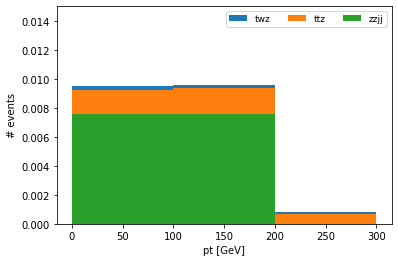

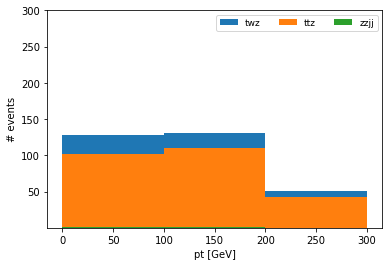

No handles with labels found to put in legend.


[array([1.169872, 1.169872, 0.      ]), array([101.1698424 , 109.41331104,  41.96674944]), array([25.42649472, 20.69243264,  8.9718112 ])]


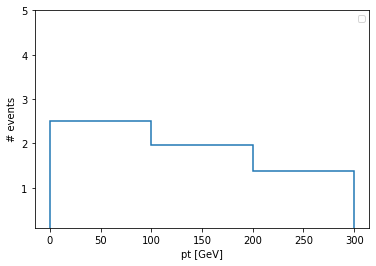

'\nplt.figure()\nhep.histplot(plot_ll_pt_true, bins=bins_ll_pt, stack=True, label=samples, histtype=\'fill\')\nplt.legend(loc=1, ncol=3, fontsize=9)\nplt.xlabel("Z pt [GeV]")\nplt.ylabel("# events")\n#plt.yscale(\'log\')\nplt.ylim([0.1, 1200])\nplt.show()\n\nplt.figure()\nhep.histplot(plot_ll_masses, bins=bins_ll_masses, stack=True, label=samples, histtype=\'fill\')\nplt.legend(loc=1, ncol=3, fontsize=9)\nplt.xlabel("mass [GeV]")\nplt.ylabel("# events")\n#plt.yscale(\'log\')\nplt.ylim([0.1, 300])\nplt.show()\n\nplt.figure()\nhep.histplot(plot_nbtag, bins=bins_nbtag, stack=False, label=samples, histtype=\'step\')\nplt.legend(loc=1, ncol=3, fontsize=9)\nplt.xlabel("n btags")\nplt.ylabel("# events")\n#plt.yscale(\'log\')\nplt.ylim([0.1, 25000])\nplt.show()\n\nplt.figure()\nhep.histplot(plot_njet, bins=bins_njet, stack=False, label=samples, histtype=\'step\')\nplt.legend(loc=1, ncol=3, fontsize=9)\nplt.xlabel("n jets")\nplt.ylabel("# events")\n#plt.yscale(\'log\')\nplt.ylim([0.1, 13000])\n

In [261]:
#bin_width = bins_ll_pt[1] - bins_ll_pt[0]
#diff_xs = plot_ll_pt[0]/(intLumi*bin_width)#
diff_xs_er = (np.sqrt(plot_zpt_diff_xs[0] + plot_zpt_diff_xs[1])) / (BR[isample]*bin_width*(len(z_pt_reco)/30000)*intLumi*1000) 

#print(bin_width)
#print(diff_xs)
print(diff_xs_er)

plt.figure()
hep.histplot(plot_zpt_diff_xs, bins=bins_ll_pt, yerr=diff_xs_er, xerr=True, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.000, 0.015])
plt.show()


plt.figure()
hep.histplot(plot_ll_pt, bins=bins_ll_pt, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.1, 300])
plt.show()

print(plot_ll_pt)

#s/sqrtb()

s_sqrt_b = plot_ll_pt[2] / ( np.sqrt( plot_ll_pt[0] + plot_ll_pt[1]  )  )

plt.figure()
hep.histplot(s_sqrt_b, bins=bins_ll_pt, stack=True, label="", histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt [GeV]")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.1,5])
plt.show()



"""
plt.figure()
hep.histplot(plot_ll_pt_true, bins=bins_ll_pt, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("Z pt [GeV]")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.1, 1200])
plt.show()

plt.figure()
hep.histplot(plot_ll_masses, bins=bins_ll_masses, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("mass [GeV]")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.1, 300])
plt.show()

plt.figure()
hep.histplot(plot_nbtag, bins=bins_nbtag, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("n btags")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.1, 25000])
plt.show()

plt.figure()
hep.histplot(plot_njet, bins=bins_njet, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("n jets")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.1, 13000])
plt.show()

plt.figure()
hep.histplot(plot_ht, bins=bins_ht, stack=True, label=samples, histtype='fill')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("ht")
plt.ylabel("# events")
#plt.yscale('log')
plt.ylim([0.1, 3075])
plt.show()
"""

In [ ]:
bins_pt_true_mu = np.linspace(0.0, 100.0, num=30)
bins_eta_true_mu = np.linspace(-5.0, 5.0, num=20)
bins_n_true_mu = np.linspace(-0.5, 6.5, num=8)

plot_pt_true_mu = []
plot_eta_true_mu = []
plot_pt_true_e = []
plot_n_true_lep = []

for isample in range(0, len(samples)):
    
    sample_name = str("delphes_output_") + str(samples[isample]) + str("_4l.root")
    eventsData = uproot.open(sample_name)["Delphes"] 
    EventWeight, EventCrossSection, JetPT, JetEta, JetBTag, MuonPT, MuonEta,  MuonPhi,  MuonT, MuonCharge, MuonIsolationVar, MuonDZ, ElectronPT, ElectronEta,  ElectronPhi,  ElectronT, ElectronCharge, ElectronIsolationVar, ParticlePID, ParticleStatus, ParticleMass, ParticlePT, ParticleEta = eventsData.arrays(["Event.Weight", "Event.CrossSection","Jet.PT", "Jet.Eta", "Jet.BTag", "Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.T", "Muon.Charge", "Muon.IsolationVar", "Muon.DZ", "Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.T", "Electron.Charge", "Electron.IsolationVar", "Particle.PID", "Particle.Status","Particle.Mass", "Particle.PT", "Particle.Eta"], outputtype=tuple)
    #eventsData.show()
    
    pt_true_mu = ParticlePT[(abs(ParticlePID)==13) & (abs(ParticleStatus)==1)  & (abs(ParticlePT)>0)]
    pt_true_e = ParticlePT[(abs(ParticlePID)==11) & (abs(ParticleStatus)==1) & (abs(ParticlePT)>0)]
    eta_true_mu = ParticleEta[(abs(ParticlePID)==13) & (abs(ParticleStatus)==1)  & (abs(ParticlePT)>0)]
    n_true_mu = ParticlePT[(abs(ParticlePID)==13) & (abs(ParticleStatus)==1)  & (abs(ParticlePT)>10)].counts
    n_true_e = ParticlePT[(abs(ParticlePID)==11) & (abs(ParticleStatus)==1) & (abs(ParticlePT)>10)].counts
    
    n_true_lep = n_true_mu + n_true_e
    print(n_true_mu)
    print(n_true_e)
    
    H_pt_true_mu, b = np.histogram(pt_true_mu.flatten(), bins=bins_pt_true_mu)
    H_pt_true_e, b = np.histogram(pt_true_e.flatten(), bins=bins_pt_true_mu)
    H_eta_true_mu, b = np.histogram(eta_true_mu.flatten(), bins=bins_eta_true_mu)
    H_n_true_lep, b = np.histogram(n_true_lep, bins=bins_n_true_mu)

    plot_pt_true_mu.append(H_pt_true_mu)
    plot_pt_true_e.append(H_pt_true_e)
    plot_eta_true_mu.append(H_eta_true_mu)
    plot_n_true_lep.append(H_n_true_lep)

plt.figure()
hep.histplot(plot_pt_true_mu, bins=bins_pt_true_mu, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt mu")
plt.ylabel("# events")
plt.yscale('log')
plt.ylim([500, 20000])
plt.show()

plt.figure()
hep.histplot(plot_pt_true_e, bins=bins_pt_true_mu, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("pt e")
plt.ylabel("# events")
plt.yscale('log')
plt.ylim([500, 120000])
plt.show()

plt.figure()
hep.histplot(plot_eta_true_mu, bins=bins_eta_true_mu, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("eta mu")
plt.ylabel("# events")
plt.yscale('log')
plt.ylim([500, 20000])
plt.show()

plt.figure()
hep.histplot(plot_n_true_lep, bins=bins_n_true_mu, stack=False, label=samples, histtype='step')
plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("N lep")
plt.ylabel("# events")
plt.yscale('log')
plt.ylim([500, 20000])
plt.show()